In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive'

In [3]:
!kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri

Dataset URL: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri
License(s): MIT
 96% 83.0M/86.8M [00:00<00:00, 96.1MB/s]
100% 86.8M/86.8M [00:00<00:00, 97.6MB/s]


In [4]:
!unzip \*.zip && rm *.zip

Archive:  brain-tumor-classification-mri.zip
  inflating: Testing/glioma_tumor/image(1).jpg  
  inflating: Testing/glioma_tumor/image(10).jpg  
  inflating: Testing/glioma_tumor/image(100).jpg  
  inflating: Testing/glioma_tumor/image(11).jpg  
  inflating: Testing/glioma_tumor/image(12).jpg  
  inflating: Testing/glioma_tumor/image(13).jpg  
  inflating: Testing/glioma_tumor/image(14).jpg  
  inflating: Testing/glioma_tumor/image(15).jpg  
  inflating: Testing/glioma_tumor/image(16).jpg  
  inflating: Testing/glioma_tumor/image(17).jpg  
  inflating: Testing/glioma_tumor/image(18).jpg  
  inflating: Testing/glioma_tumor/image(19).jpg  
  inflating: Testing/glioma_tumor/image(2).jpg  
  inflating: Testing/glioma_tumor/image(20).jpg  
  inflating: Testing/glioma_tumor/image(21).jpg  
  inflating: Testing/glioma_tumor/image(22).jpg  
  inflating: Testing/glioma_tumor/image(23).jpg  
  inflating: Testing/glioma_tumor/image(24).jpg  
  inflating: Testing/glioma_tumor/image(25).jpg  
  infl

In [5]:
import torch  #torch and its submodules for foundational PyTorch functionality.
import torch.nn as nn  #torch.nn for neural network modules and operations.
import torch.optim as optim   #torch.optim for optimization algorithms.
import torchvision   #torchvision for handling datasets, such as CIFAR-10 or your custom brain tumor dataset.
import torchvision.transforms as transforms   #torchvision.transforms for data transformations.
import matplotlib.pyplot as plt   #matplotlib.pyplot for plotting images and graphs.
import numpy as np   #numpy for numerical computations.
from torch.utils.data import DataLoader

In [6]:
from torchvision.datasets import ImageFolder

# Define the paths to your training and test data folders
train_data_dir = "/content/Training"
test_data_dir = "/content/Testing"

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
train_dataset = ImageFolder(root=train_data_dir, transform=transform)
test_dataset = ImageFolder(root=test_data_dir, transform=transform)

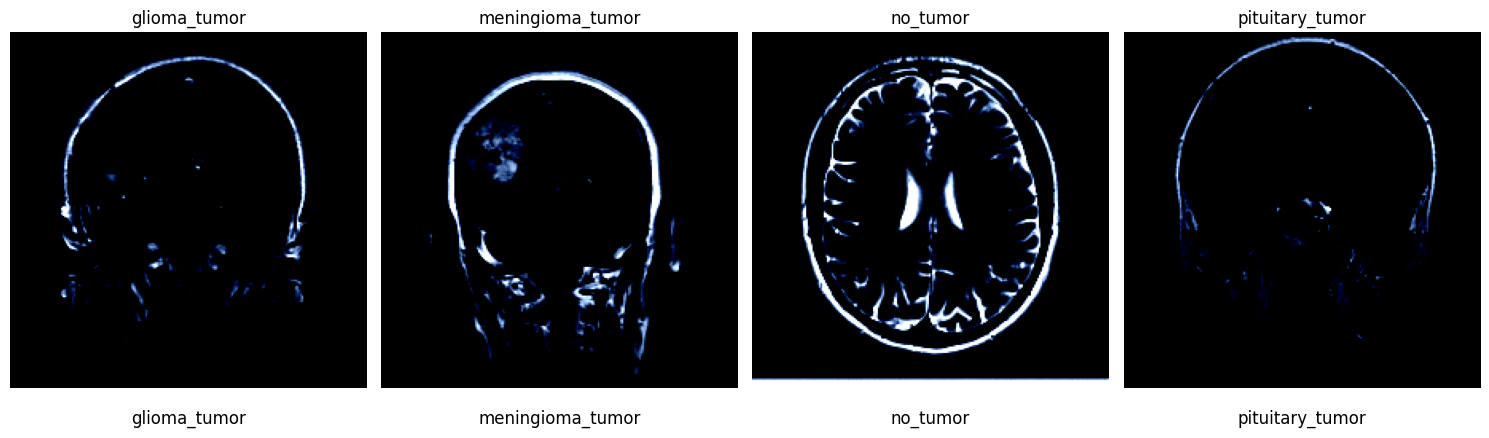

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

def visualize_class_samples(dataset):
    classes = dataset.classes

    # Create a figure with subplots
    fig, axes = plt.subplots(1, len(classes), figsize=(15, 5))

    # Loop through each class
    for i, cls in enumerate(classes):
        indices = np.where(np.array(dataset.targets) == i)[0]  # Indices of samples in this class
        selected_idx = np.random.choice(indices, size=1, replace=False)[0]  # Choose one image index

        image, _ = dataset[selected_idx]
        ax = axes[i]
        ax.imshow(np.transpose(image.numpy(), (1, 2, 0)))  # Transpose to (H, W, C)
        ax.set_title(cls)
        ax.axis('off')

        ax.text(0.5, -0.1, cls, transform=ax.transAxes, fontsize=12, ha='center')

    plt.tight_layout()
    plt.show()

# Visualize a single representative image from each class with class names
visualize_class_samples(train_dataset)

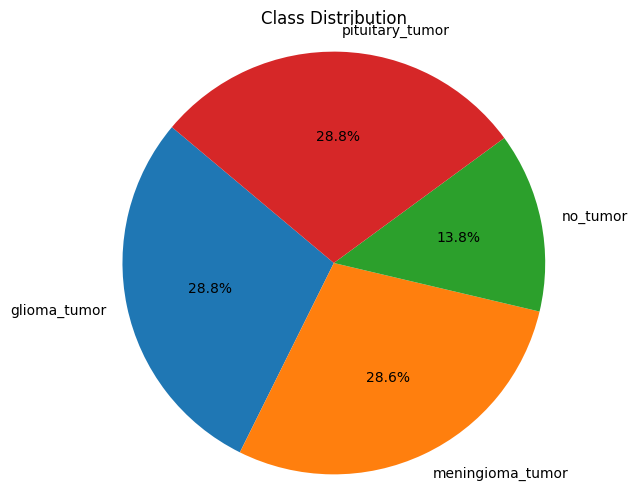

In [10]:
import matplotlib.pyplot as plt

def visualize_class_distribution(dataset):
    classes = dataset.classes
    class_counts = [0] * len(classes)

    # Count the number of samples in each class
    for _, label in dataset:
        class_counts[label] += 1

    # Create a pie chart
    plt.figure(figsize=(6, 6))
    plt.pie(class_counts, labels=classes, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular
    plt.title('Class Distribution')

    plt.show()

# Visualize the distribution of images across classes
visualize_class_distribution(train_dataset)


In [11]:
from torch.utils.data import random_split

# Assuming you have already loaded the full training dataset into 'train_dataset'

# Define the size of the validation set
validation_ratio = 0.1  # 10% of the dataset

# Calculate the sizes of the training and validation sets
train_size = int((1 - validation_ratio) * len(train_dataset))
val_size = len(train_dataset) - train_size

# Use random_split to split the dataset into training and validation sets
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

In [12]:
batch_size = 32
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TumorClassifier(nn.Module):
    def __init__(self, num_classes):
        super(TumorClassifier, self).__init__()
        # Convolutional layer with 16 output channels, 3x3 kernel, and padding of 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        # Max pooling layer with 2x2 kernel and stride of 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Fully connected layer with 16 * 112 * 112 input features and 128 output features
        self.fc1 = nn.Linear(16 * 112 * 112, 128)
        # Fully connected layer with 128 input features and 'num_classes' output features
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Apply convolutional layer, ReLU activation, and max pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Reshape the feature maps for the fully connected layer
        x = x.view(-1, 16 * 112 * 112)
        # Apply the first fully connected layer and ReLU activation
        x = F.relu(self.fc1(x))
        # Apply the final fully connected layer without an activation function
        x = self.fc2(x)
        return x

In [14]:
# Instantiate your model
model = TumorClassifier(num_classes=4)
# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Set the number of epochs
num_epochs = 5

# Lists to store training and validation metrics
train_losses = []
val_losses = []
train_f1s = []
val_f1s = []
train_precisions = []
val_precisions = []
train_recalls = []
val_recalls = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode

    running_loss = 0.0  # Initialize the loss accumulator for this epoch
    all_labels_train = []  # Initialize a list to store all ground truth labels
    all_predictions_train = []  # Initialize a list to store all predicted labels

    # Training loop
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()  # Reset gradients to zero
        outputs = model(inputs)  # Forward pass through the model
        loss = criterion(outputs, labels)  # Calculate the loss
        loss.backward()  # Backpropagation to compute gradients
        optimizer.step()  # Update model parameters using the computed gradients

        running_loss += loss.item()  # Accumulate the loss for this batch
        all_labels_train.extend(labels.cpu().numpy())  # Collect ground truth labels
        _, predicted = torch.max(outputs, 1)  # Get the predicted class labels
        all_predictions_train.extend(predicted.cpu().numpy())  # Collect predicted labels

    # Calculate training metrics
    train_f1 = f1_score(all_labels_train, all_predictions_train, average='weighted')
    train_precision = precision_score(all_labels_train, all_predictions_train, average='weighted')
    train_recall = recall_score(all_labels_train, all_predictions_train, average='weighted')
    train_epoch_loss = running_loss / len(train_dataloader)  # Calculate average training loss

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    all_labels_val = []  # Initialize a list to store all validation ground truth labels
    all_predictions_val = []  # Initialize a list to store all validation predicted labels

    val_running_loss = 0.0  # Initialize the validation loss accumulator
    for inputs, labels in val_dataloader:
        outputs = model(inputs)  # Forward pass through the model
        loss = criterion(outputs, labels)  # Calculate the loss for validation (optional)
        val_running_loss += loss.item()  # Accumulate the validation loss for this batch

        _, predicted = torch.max(outputs, 1)  # Get the predicted class labels
        all_labels_val.extend(labels.cpu().numpy())  # Collect validation ground truth labels
        all_predictions_val.extend(predicted.cpu().numpy())  # Collect validation predicted labels

    # Calculate validation metrics
    val_f1 = f1_score(all_labels_val, all_predictions_val, average='weighted')
    val_precision = precision_score(all_labels_val, all_predictions_val, average='weighted')
    val_recall = recall_score(all_labels_val, all_predictions_val, average='weighted')
    val_epoch_loss = val_running_loss / len(val_dataloader)  # Calculate average validation loss

    # Append metric values to lists for tracking
    train_losses.append(train_epoch_loss)
    val_losses.append(val_epoch_loss)
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)
    train_precisions.append(train_precision)
    val_precisions.append(val_precision)
    train_recalls.append(train_recall)
    val_recalls.append(val_recall)

    # Print metrics for both training and validation
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_epoch_loss:.4f}, Val Loss: {val_epoch_loss:.4f}, "
          f"Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}, "
          f"Train Precision: {train_precision:.4f}, Val Precision: {val_precision:.4f}, "
          f"Train Recall: {train_recall:.4f}, Val Recall: {val_recall:.4f}")


Epoch [1/5], Train Loss: 3.7913, Val Loss: 0.7750, Train F1: 0.5774, Val F1: 0.7133, Train Precision: 0.5758, Val Precision: 0.7604, Train Recall: 0.5803, Val Recall: 0.7247
Epoch [2/5], Train Loss: 0.4784, Val Loss: 0.4685, Train F1: 0.8276, Val F1: 0.8133, Train Precision: 0.8278, Val Precision: 0.8198, Train Recall: 0.8285, Val Recall: 0.8118
Epoch [3/5], Train Loss: 0.2525, Val Loss: 0.4606, Train F1: 0.9199, Val F1: 0.8438, Train Precision: 0.9203, Val Precision: 0.8571, Train Recall: 0.9199, Val Recall: 0.8397
Epoch [4/5], Train Loss: 0.1307, Val Loss: 0.4093, Train F1: 0.9675, Val F1: 0.8580, Train Precision: 0.9677, Val Precision: 0.8607, Train Recall: 0.9675, Val Recall: 0.8571
Epoch [5/5], Train Loss: 0.0665, Val Loss: 0.4011, Train F1: 0.9880, Val F1: 0.8543, Train Precision: 0.9880, Val Precision: 0.8621, Train Recall: 0.9880, Val Recall: 0.8537


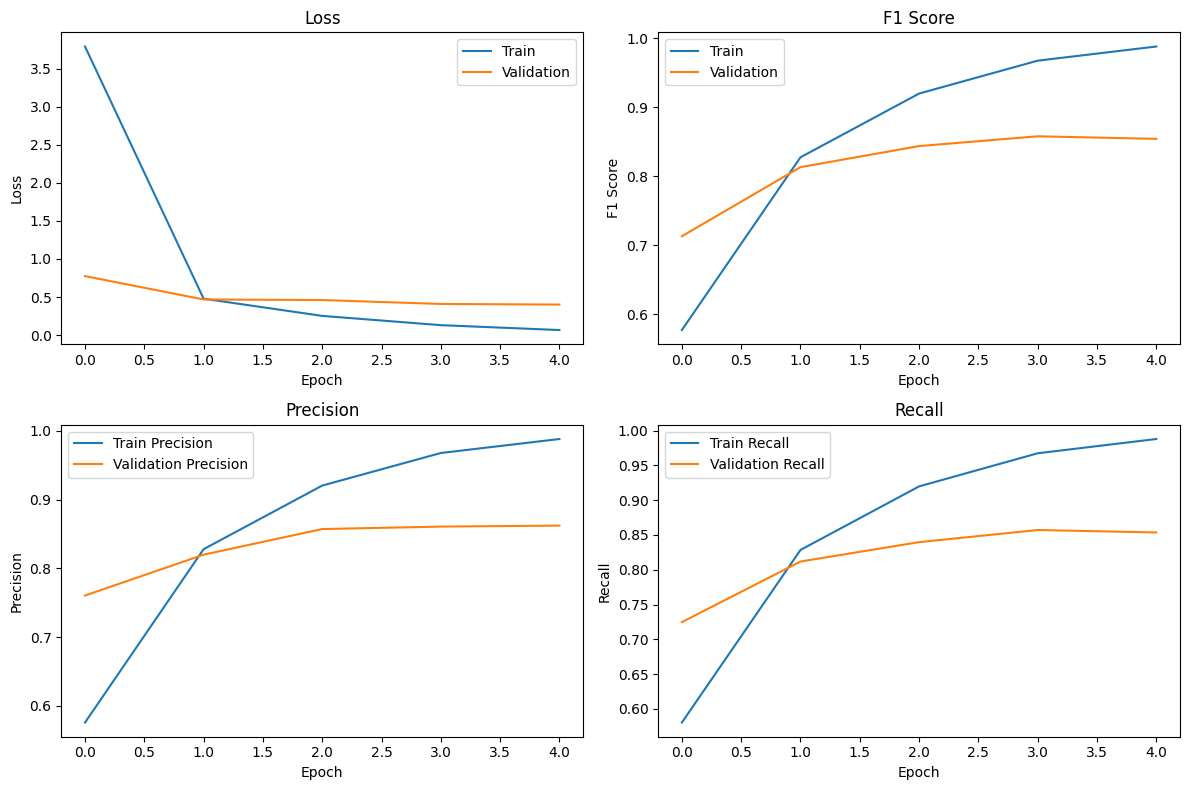

In [16]:
# Create plots using the metric lists
plt.figure(figsize=(12, 8))

# Plot Loss
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot F1 Score
plt.subplot(2, 2, 2)  # Corrected subplot index
plt.plot(train_f1s, label='Train')
plt.plot(val_f1s, label='Validation')
plt.title('F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

# Plot Precision
plt.subplot(2, 2, 3)  # Corrected subplot index
plt.plot(train_precisions, label='Train Precision')
plt.plot(val_precisions, label='Validation Precision')
plt.title('Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Plot Recall
plt.subplot(2, 2, 4)  # Corrected subplot index
plt.plot(train_recalls, label='Train Recall')
plt.plot(val_recalls, label='Validation Recall')
plt.title('Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()


In [17]:
def evaluate_model_on_dataset(model, dataloader):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())


    f1 = f1_score(all_labels, all_predictions, average='weighted')
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')

    return  f1, precision, recall

# Evaluate model on the test dataset
test_f1, test_precision, test_recall = evaluate_model_on_dataset(model, test_dataloader)

print(
      f"Test F1_score: {test_f1:.4f}, "
      f"Test Precision: {test_precision:.4f}, "
      f"Test Recall: {test_recall:.4f}")


Test F1_score: 0.6799, Test Precision: 0.7557, Test Recall: 0.7208


In [18]:
from sklearn.metrics import classification_report

# Evaluate model on the test dataset
test_predictions = []
true_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        test_predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print("Classification Report:")
print(classification_report(true_labels, test_predictions))

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.23      0.36       100
           1       0.72      0.97      0.83       115
           2       0.65      0.96      0.77       105
           3       0.88      0.66      0.75        74

    accuracy                           0.72       394
   macro avg       0.77      0.70      0.68       394
weighted avg       0.76      0.72      0.68       394

